# FIT3139 Final Project

## Learning outcomes

1.  Explain and apply the process of computational scientific model building, verification and interpretation
2.  Analyse the differences between core classes of modelling approaches (Numerical versus Analytical; Linear versus Non-linear; Continuous versus Discrete; Deterministic versus Stochastic)
3.   Evaluate the implications of choosing different modelling approaches;
4.   Rationalise the role of simulation and data visualisation in science;
5.   Apply all of the above to solving idealisations of real-world problems across various scientific disciplines.

## Specification table
|||
|------------|---|
| Base Model | Tennis simulation |
| Extension assumpion | Simulate a complete season based on skill distribution |
| Techniques showcaed | Markov chains, montecarlo simulations |
| Modelling question 1 |  |
| Modelling question 2 | |

## Section 2: Introduction

### THe problem and the motivation

The primary problem addressed in this project is to understand the impact of skill distribution on player rankings in a tennis season. Additionally, the project aims to determine whether longer matches or longer seasons are more effective in revealing the true quality of players. This problem is motivated by the need to ensure fairness and accuracy in competitive sports, where ranking systems often determine players' career.

### Describe the extension and the questions my model will answer

I'm simulating a tennis match using markov chains. The extension is to simulate a complete season based on skill distribution. The base model discussed earlier used markov chain with "some" probability to move to a next point, which didn't take into account the skill level of a player. This extension will simplify the states in the transition matrix but will add complexity to take into account the player's serving and returning skills. The model will answer the following questions:

1. How does the skill distribution of players affect the outcome of a tennis tournament?
2. Comparing initial skill distribution vs point distribution at the end of the tournament.
3. What is more effective in revealing the true quality of players: longer matches or longer tournaments?

This question can be answered using other techniques such as game theory, however I have chosen markov chains as I believe it more accurately models a tennis players' skill level and allows me to examine how players of different skill levels perform in a match and whether they have any liklihood of winning. 
Sports do have a certain level of strategy involved, however given that I am using markov chains I am not considering that in this model and instead assuming that a player will always play the best shot possible, allowing me to focus on the skill level of a player.


### The rules of tennis
#### Points:
Each game starts with a serve and players alternate serving every game. Points are scored as follows: 0 (Love), 15, 30, 40, and game point.

#### Games:
A player wins a game by scoring four points and leading by at least two points. If the score reaches 40-40, the game is in deuce, and a player must win two consecutive points to win the game.

#### Sets:
A player wins a set by winning six games and leading by at least two games. If the score reaches 6-6, a tiebreaker is played to determine the winner of the set.

#### Match:
A player wins a match by winning the best of three or five sets.



## Section 3: Model description

### Model extension details

The base model used a markov chain to simulate a tennis match with equal probability for moving on to the next possible score. The extension will use a markov chain but will take into account the skill level of the players. Each player contains 2 skills - a serve and return skill. These skills will be represented by a number between 0 and 1, where 0 is the lowest skill level and 1 is the highest skill level.

The skill level of a players will be used to create a transition matrix. The creation of the transition matrix is based on the skill level of the 2 provided players.

The skill level will be used to determine the probability of a player winning a point when serving or returning. The skill level will be used to adjust the transition matrix probabilities to reflect the player's skill level. The model will simulate a complete season based on the skill distribution of the players


### Model assumptions

### Class of the model
#### Linear vs Non-linear


#### Continuous vs Discrete
##### Why discrete?
The model is discrete as the state space is finite and the transitions between states are discrete. The model is based on the outcome of each point in a tennis match. The model transitions between these states [serve, return, rally] based on the probability of transitioning to one of these states before stopping at one of the absorbing states where either the server wins or the returner wins. The model is discrete as the outcome of each point is an absolute value decided based on the transition matrices.

##### Why not continuous? 
Simulating a tennis match using a continuous model is not appropriate for answering my questions because I am only interested in the outcome of each point at the lowest level which is either a win or a loss (tennis does not have ties/draws). A continuous model could have been helpful if I was interested in the score of the match at any given point in time.

#### Deterministic vs Stochastic
In this markov chain tennis simulation, the model is stochastic as the outcome of each point is determined by a probability distribution. Each player has a skill level in terms of serving and returning, which affects the probability of winning a point. A higher serving level increases the likelihood of winning a point directly (ace) however, if the opponent has a high returning skill this probability is reduced/normalised to account for the opponent's skill level. Each point starts with one of the players serving; from this serving state the model transitions to one of the other possible transient states and the point end when either the server or returner wins a point. Given that each step is probabilistic, the model is stochastic.

### Algorithms being used


In [197]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

### Transition matrix example

In my markov chain model, the transition matrix is a 5x5 matrix with the following states/structure:

S1: Serve

S2: Return

S3: Rally

S4: Point won by server

S5: Point won by returner

The transition matrix is as follows:

|    | S1 | S2  | S3  | S4   | S5   |
|----|----|-----|-----|------|------|
| S1 | 0  | 0.6 | 0   | 0.2  | 0.2  |
| S2 | 0  | 0   | 0.7 | 0.15 | 0.15 |
| S3 | 0  | 0   | 0.5 | 025  | 0.25 |
| S4 | 0  | 0   | 0   | 1    | 0    |
| S5 | 0  | 0   | 0   | 0    | 1    |


And in its canonical form:
From this matrix, we can extract the canonical form:

$$
\begin{align*}

\begin{pmatrix}
Q & R \\
0 & I \\
\end{pmatrix} & =

\begin{pmatrix}
0 & 0.6 & 0 & 0.2 & 0.2 \\
0 & 0 & 0.7 & 0.15 & 0.15 \\
0 & 0 & 0.5 & 0.25 & 0.25 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}

\\

Q & =
\begin{pmatrix}
0 & 0.6 & 0 \\
0 & 0 & 0.7 \\
0 & 0 & 0.5 \\
\end{pmatrix}


& R &=
\begin{pmatrix}
0.2 & 0.2 \\
0.15 & 0.15 \\
0.25 & 0.25 \\
\end{pmatrix}

\\

0 & =
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{pmatrix}


& I &=
\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}

\end{align*}
$$

Getting the fundamental matrix:

$$
\begin{align*}
& N = (I - Q)^{-1} \\

& N = 
\begin{pmatrix}
1 & -0.6 & 0 \\
0 & 1 & -0.7 \\
0 & 0 & 1 \\
\end{pmatrix}^{-1} \\


\end{align*}
$$

See below for calculations

#### Caluclation for the example transition matrix

In [198]:
M = np.array([
    [0, 0.6, 0, 0.2, 0.2],
    [0, 0, 0.7, 0.15, 0.15],
    [0, 0, 0.5, 0.25, 0.25],
    [0, 0 ,0 ,1, 0],
    [0, 0, 0, 0, 1]
])
D = np.diag(M)
absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
print("Absorbing states:", absorbing)  # rows 3 and 4
print("Transient states:", transient)  # rows 0, 1, 2

Absorbing states: [3 4]
Transient states: [0 1 2]


In [199]:
Q = M[:3,:3]
R = M[:3,3:]
N = np.linalg.inv(np.eye(3) - Q) # Fundamental matrix
expected_visits = np.sum(N, axis=1)
least_visitied = transient[np.argmin(expected_visits)]
absorbtion_time = N.dot(np.ones_like(transient))
total_time = np.sum(absorbtion_time)
# Probability of absoption = B_{ij} = NR
absorbtion_probabilities = N.dot(R)  # B = N * R

print("Expected visits:", expected_visits)
print("Least visited state:", least_visitied)
print("Absorbtion time:", absorbtion_time)
print("Total time:", total_time)
print("Absorbtion probabilities:\n", absorbtion_probabilities)

Expected visits: [2.44 2.4  2.  ]
Least visited state: 2
Absorbtion time: [2.44 2.4  2.  ]
Total time: 6.84
Absorbtion probabilities:
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


The probability of reaching a state $M_{ij}$ in $n$ steps is given by $P_{ij}(n) = M^n_{ij}$

This formula is useful to examine the probability of reaching a state after a certain number of steps.

In [200]:
# calculating P_{ij}^{(n)} = M_{ij}^{(n)}
P = lambda n: np.linalg.matrix_power(M, n)
print("P_{ij}^{(1)}:\n", P(1))
print("P_{ij}^{(2)}:\n", P(2))
print("...")
print("P_{ij}^{(9)}:\n", P(9))

P_{ij}^{(1)}:
 [[0.   0.6  0.   0.2  0.2 ]
 [0.   0.   0.7  0.15 0.15]
 [0.   0.   0.5  0.25 0.25]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]
P_{ij}^{(2)}:
 [[0.    0.    0.42  0.29  0.29 ]
 [0.    0.    0.35  0.325 0.325]
 [0.    0.    0.25  0.375 0.375]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.   ]]
...
P_{ij}^{(9)}:
 [[0.         0.         0.00328125 0.49835937 0.49835937]
 [0.         0.         0.00273437 0.49863281 0.49863281]
 [0.         0.         0.00195312 0.49902344 0.49902344]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


We can see that as the number of steps increases, the probability of absorbing into either the server or returner winning increases, and we can also see that the probabilities of those 2 states is approaching 0.5.

## Section 4: Results

### Interpret and analyse my results

### How I arrived at my results


## Section 5: List of algorithms and concepts

### Markov chains - how it plays a role in my model

In [292]:
def proportional_scaling(arr, max_val=1.0):
    arr = np.array(arr)
    total = np.sum(arr)
    if total == 0:
        return arr
    # return [max_val * x / total for x in arr]
    return max_val * arr / total

@dataclass
class Player:
    Serve: float
    Return: float
    sets: int = 0
    games: int = 0
    score: int = 0
    wins: int = 0

    def __setitem__(self, key, value):
        setattr(self, key, value)

    def __getitem__(self, item):
        return getattr(self, item)

In [202]:
def create_transition_matrix(server_skill: int, returner_skill: int):
    # Ensure skills are between 0 and 1
    server_skill = np.clip(server_skill, 0, 1)
    returner_skill = np.clip(returner_skill, 0, 1)
    
    # Probabilities of success for each action
    p_return_success = returner_skill
    p_serve_win_direct = 1 - returner_skill
    p_serve_loss_direct = 1 - server_skill

    # Probabilities of failure for each action
    p_rally_continue = 1 - np.max([server_skill, returner_skill])
    p_server_win = 1 - returner_skill
    p_returner_win = 1 - server_skill
    p_rally_server_win = 1 - returner_skill
    p_rally_returner_win = 1 - server_skill
    
    # p_server_win, p_returner_win = proportional_scaling([server_skill, returner_skill], p_rally_continue)
    # p_rally_server_win, p_rally_returner_win = proportional_scaling([p_server_win, p_returner_win], p_rally_continue)
  
    
    # Transition matrix
    transition_matrix = np.array([
        proportional_scaling([0.0, p_return_success, 0.0, p_serve_win_direct, p_serve_loss_direct]),  # Serve
        proportional_scaling([0.0, 0.0, p_rally_continue, p_server_win, p_returner_win]), # Return
        proportional_scaling([0.0, 0.0, p_rally_continue, p_rally_server_win, p_rally_returner_win ]), # Rally
        [0.0, 0.0, 0.0, 1.0, 0.0],   # Point Won by Server (Terminal)
        [0.0, 0.0, 0.0, 0.0, 1.0]    # Point Won by Returner (Terminal)
    ])
    
    return transition_matrix

def create_transition_matrices(player1: Player, player2: Player):
    # Transition matrix for player 1 serving
    transition_matrix_serve_p1 = create_transition_matrix(player1.Serve, player2.Return)
    # Transition matrix for player 2 serving
    transition_matrix_serve_p2 = create_transition_matrix(player2.Serve, player1.Return)
    return transition_matrix_serve_p1, transition_matrix_serve_p2

# Example usage:
server_skill = 0.8  # High skill server
returner_skill = 0.4  # Moderate skill returner

transition_matrix = create_transition_matrix(server_skill, returner_skill)
print(transition_matrix)


[[0.         0.33333333 0.         0.5        0.16666667]
 [0.         0.         0.2        0.6        0.2       ]
 [0.         0.         0.2        0.6        0.2       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


In [203]:
states = ["Serve", "Return", "Rally", "Point Won by Server", "Point Won by Returner"]

def simulate_point(transition_matrix, initial_state=0):
    current_state = initial_state
    steps = 0
    while current_state < 3:
        current_state = np.random.choice(range(5), p=transition_matrix[current_state])
        steps += 1
    return current_state, steps

def simulate_game(player1, player2, transition_matrices, current_server=None):
    player1["score"] = 0
    player2["score"] = 0
    current_server = np.random.choice([0, 1]) if current_server is None else current_server
    while True:
        current_server = 1 - current_server
        winner, _ = simulate_point(transition_matrices[current_server])
        if current_server == 0:
            player1["score"] += 1 if winner == 3 else 0
            player2["score"] += 1 if winner == 4 else 0
        else:
            player1["score"] += 1 if winner == 4 else 0
            player2["score"] += 1 if winner == 3 else 0
        
        if player1["score"] >= 4 and player1["score"] >= player2["score"] + 2:
            break
        if player2["score"] >= 4 and player2["score"] >= player1["score"] + 2:
            break
            

    return player1["score"], player2["score"]

def simulate_set(player1, player2, transition_matrices):
    player1["games"] = 0
    player2["games"] = 0
    while True:
        score = simulate_game(player1, player2, transition_matrices)
        winner = 0 if score[0] > score[1] else 1
        player1["games"] += 1 if winner == 0 else 0
        player2["games"] += 1 if winner == 1 else 0
        
        # if 6 all, play tiebreak
        if player1["games"] == 6 and player2["games"] == 6:
            score = simulate_game(player1, player2, transition_matrices, current_server=winner)
            winner = 0 if score[0] > score[1] else 1
            player1["games"] += 1 if winner == 0 else 0
            player2["games"] += 1 if winner == 1 else 0
            break

        if player1["games"] >= 6 and player1["games"] >= player2["games"] + 2:
            break
        if player2["games"] >= 6 and player2["games"] >= player1["games"] + 2:
            break

    return player1["games"], player2["games"]

def simulate_match(player1, player2, transition_matrices, best_of=3):
    player1["sets"] = 0
    player2["sets"] = 0
    required_sets = (best_of + 1) // 2

    while True:
        score = simulate_set(player1, player2, transition_matrices)
        winner = 0 if score[0] > score[1] else 1
        player1["sets"] += 1 if winner == 0 else 0
        player2["sets"] += 1 if winner == 1 else 0

        if player1["sets"] >= required_sets:
            break
        if player2["sets"] >= required_sets:
            break

    return player1["sets"], player2["sets"]


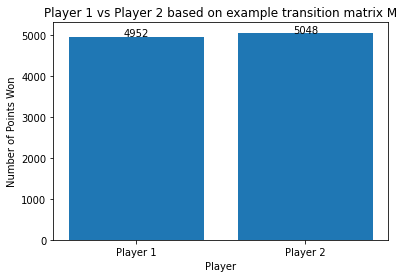

In [279]:
stats = {
    "Player 1": 0,
    "Player 2": 0,
}

for _ in range(10000):
    simulation = simulate_point(M)
    stats["Player 1"] += 1 if simulation[0] == 3 else 0
    stats["Player 2"] += 1 if simulation[0] == 4 else 0

plt.bar(stats.keys(), stats.values())
plt.xlabel("Players")
plt.ylabel("Number of Points Won")
plt.title("Player 1 vs Player 2 based on example transition matrix M")
for key, value in stats.items():
    plt.text(key, value, str(value), ha="center")
plt.show()

In [204]:
player1 = Player(0.7, 0.8)
player2 = Player(0.9, 0.4)
transition_matrices = create_transition_matrices(player1, player2)
simulate_match(player1, player2, transition_matrices)   

(2, 1)

In [304]:
class SingleEliminationTournament:
    def __init__(self, players, best_of=3):
        self.players = players
        self.best_of = best_of
        self.results = None

    def simulate_round(self):
        winners = []
        for i in range(0, len(self.results), 2):
            player1, player2 = self.results[i], self.results[i + 1]
            transition_matrices = create_transition_matrices(player1, player2)
            winner = simulate_match(player1, player2, transition_matrices, best_of=self.best_of)
            winners.append(self.results[i] if winner[0] > winner[1] else self.results[i + 1])
        self.results = winners
    
    def simulate(self):
        self.results = self.players
        while len(self.results) > 1:
            self.simulate_round()
            # for each winner, add 1 to their wins
            for player in self.results:
                player["wins"] += 1

        print(self.results)
    
        

players = [
    Player(0.7, 0.8),
    Player(0.9, 0.4),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.8, 0.7),
    Player(0.4, 0.9),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
]

tournament = SingleEliminationTournament(players, best_of=3)
tournament.simulate()
tournament.players

[Player(Serve=0.9, Return=0.4, sets=2, games=7, score=4, wins=3)]


[Player(Serve=0.7, Return=0.8, sets=1, games=6, score=4, wins=0),
 Player(Serve=0.9, Return=0.4, sets=2, games=7, score=4, wins=3),
 Player(Serve=0.6, Return=0.6, sets=1, games=4, score=3, wins=1),
 Player(Serve=0.5, Return=0.5, sets=0, games=2, score=1, wins=0),
 Player(Serve=0.8, Return=0.7, sets=1, games=4, score=1, wins=0),
 Player(Serve=0.4, Return=0.9, sets=0, games=6, score=2, wins=2),
 Player(Serve=0.6, Return=0.6, sets=0, games=1, score=2, wins=1),
 Player(Serve=0.5, Return=0.5, sets=0, games=4, score=3, wins=0)]

In [206]:
player1 = Player(0.7, 0.8)
player2 = Player(0.9, 0.4)

# simulate a point many times
def _monte_carlo_point(player1, player2, reps=1000):
    winner_player1_serving = {
        "player1": 0,
        "player2": 0
    }
    winner_player2_serving = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    
    for _ in range(reps):
        winner1, _ = simulate_point(transition_matrices[0])
        winner2, _ = simulate_point(transition_matrices[1])

        # winner 1 is when player 1 serves
        winner_player1_serving["player1"] += 1 if winner1 == 3 else 0
        winner_player1_serving["player2"] += 1 if winner1 == 4 else 0

        # winner 2 is when player 2 serves
        winner_player2_serving["player1"] += 1 if winner2 == 4 else 0
        winner_player2_serving["player2"] += 1 if winner2 == 3 else 0
    return "point", winner_player1_serving, winner_player2_serving

# simulate a set many times
def _monte_carlo_game(player1, player2, reps=1000):
    winner_player1 = {
        "player1": 0,
        "player2": 0
    }
    winner_player2 = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    for _ in range(reps):
        winner1 = simulate_game(player1, player2, transition_matrices)
        winner2 = simulate_game(player2, player1, transition_matrices)

        winner_player1["player1"] += 1 if winner1[0] > winner1[1] else 0
        winner_player1["player2"] += 1 if winner1[0] < winner1[1] else 0

        winner_player2["player2"] += 1 if winner2[0] > winner2[1] else 0
        winner_player2["player1"] += 1 if winner2[0] < winner2[1] else 0

    return "set", winner_player1, winner_player2

# simulate a game many times
def _monte_carlo_set(player1, player2, reps=1000):
    winners = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    
    for _ in range(reps):
        winner = simulate_set(player1, player2, transition_matrices)
        winners["player1"] += 1 if winner[0] > winner[1] else 0
        winners["player2"] += 1 if winner[0] < winner[1] else 0

    return "game", winners

# simulate a match many times
def _monte_carlo_match(player1, player2, reps=1000, best_of=3):
    winners = {
        "player1": 0,
        "player2": 0
    }
    transition_matrices = create_transition_matrices(player1, player2)
    
    for _ in range(reps):
        winner = simulate_match(player1, player2, transition_matrices, best_of=best_of)
        winners["player1"] += 1 if winner[0] > winner[1] else 0
        winners["player2"] += 1 if winner[0] < winner[1] else 0

    return "match", winners

def plot_monte_carlo_simulation(player1: Player, player2: Player, function, reps=1000) -> None:
    winners = function(player1, player2, reps)

    if len(winners) == 3:
        text, winner_player1_serving, winner_player2_serving = winners
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"Monte Carlo Simulation of a {text}")
        ax[0].bar(winner_player1_serving.keys(), winner_player1_serving.values())
        ax[0].bar_label(ax[0].containers[0])
        ax[0].set_title("Player 1 Serving")
        ax[0].set_xlabel("Winner")
        ax[0].set_ylabel("Frequency")

        ax[1].bar(winner_player2_serving.keys(), winner_player2_serving.values())
        ax[1].bar_label(ax[1].containers[0])
        ax[1].set_title("Player 2 Serving")
        ax[1].set_xlabel("Winner")
        ax[1].set_ylabel("Frequency")
        plt.show()

    elif len(winners) == 2:
        text, winners = winners
        fig, ax = plt.subplots()
        fig.suptitle(f"Monte Carlo Simulation of a {text}")
        ax.bar(winners.keys(), winners.values())
        ax.bar_label(ax.containers[0])
        ax.set_title(text)
        ax.set_xlabel("Winner")
        ax.set_ylabel("Frequency")
        plt.show()
  

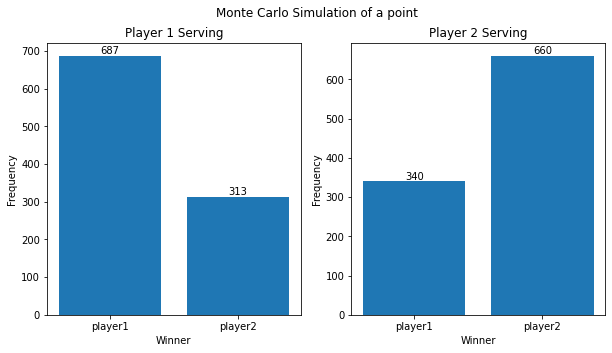

In [207]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_point)

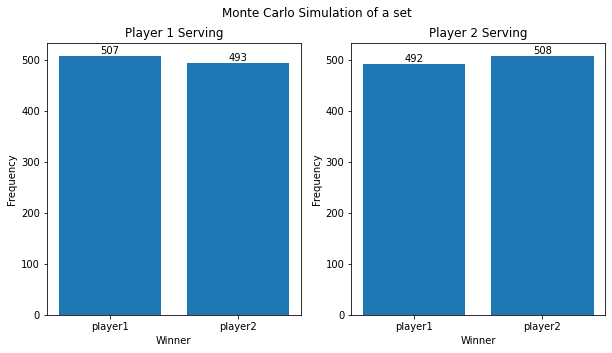

In [208]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_game)

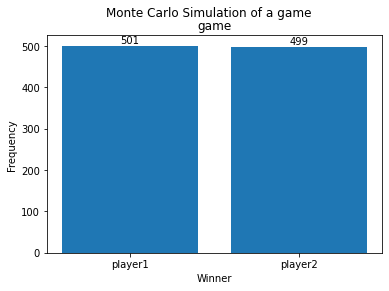

In [214]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_set)

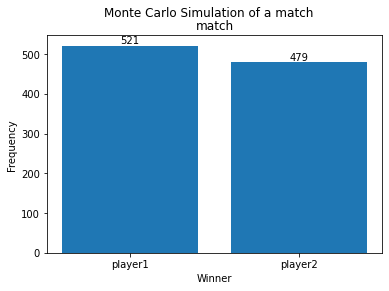

In [215]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_match)

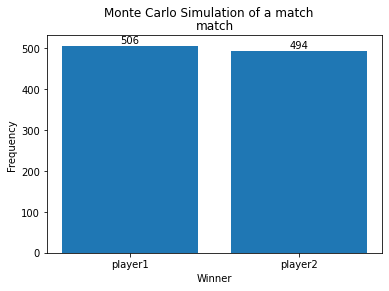

In [211]:
# plot monte carlo mathc with best of 5
plot_monte_carlo_simulation(player1, player2, lambda x, y, z: _monte_carlo_match(x, y, z, best_of=5))

C:\Users\rishi\AppData\Local\Temp\ipykernel_49220\3852250018.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


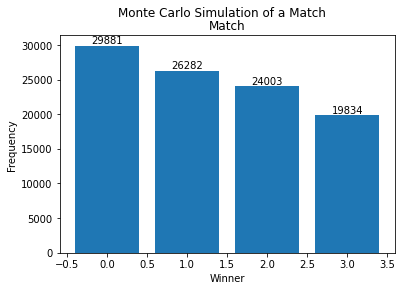

In [212]:
# showing that serve + return / 2 gives apprxiately the same result
players = np.array([
    Player(0.7, 0.8),
    Player(0.9, 0.4),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
])

player_skill_level = np.vectorize(lambda x: (x.Serve + x.Return) / 2)(players)
p=proportional_scaling(player_skill_level)
sims=100000
winners = np.zeros(sims)

for i in range(sims):
    winner = np.random.choice(range(len(players)), p=p)
    winners[i] = winner

# change winners keys to player number
unique, counts = np.unique(winners, return_counts=True)
winners = dict(zip(unique, counts))

fig, ax = plt.subplots()
fig.suptitle("Monte Carlo Simulation of a Match")
ax.bar(winners.keys(), winners.values())
ax.bar_label(ax.containers[0])
ax.set_title("Match")
ax.set_xlabel("Winner")
ax.set_ylabel("Frequency")
fig.show()


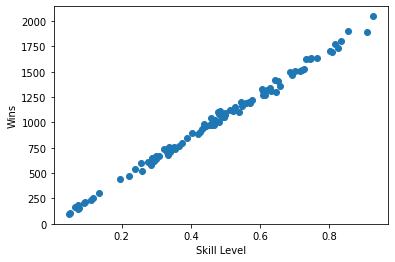

In [213]:
# Montecarlo simulation
# let the skill level of the players be server + return / 2

simulations = 100000
players = []
for _ in range(100):
    player = {
        "Serve": np.random.random(),
        "Return": np.random.random()
    }
    players.append(player)

player_skill_level = [(p["Serve"] + p["Return"]) / 2 for p in players]
# player skill level determines the probability of winning a point
# plot a histogram showing which player won the most points

winners = []
for _ in range(simulations):
    winner = np.random.choice(range(100), p=proportional_scaling(player_skill_level))
    winners.append(winner)

# plot skill level vs number of wins
plt.scatter(player_skill_level, [winners.count(i) for i in range(100)])
plt.xlabel("Skill Level")
plt.ylabel("Wins")
plt.show()